<a href="https://colab.research.google.com/github/niteshg97/KidneyViT-A-Vision-Transformer-for-Classifying-Kidney-Abnormalities/blob/main/KidneyViT_A_Vision_Transformer_for_Classifying_Kidney_Abnormalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive
from google.colab import drive
import os

print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [2]:
# Data copy from Drive to Colab file for faster training
import time
print("--- Starting CORRECTED Data Copy ---")
start_time = time.time()
drive_path = "/content/drive/MyDrive/Kidney_Cancer_Project/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/*"
local_path = "/tmp/CT-KIDNEY-DATASET"
!mkdir -p "{local_path}"
!cp -r {drive_path} "{local_path}"
end_time = time.time()
print(f"--- Copy finished in {end_time - start_time:.2f} seconds ---")

--- Starting CORRECTED Data Copy ---
--- Copy finished in 129.60 seconds ---


--- Plotting Class Distribution ---
Class counts:
    Class  Count
0    Cyst   3709
1  Normal   5077
2   Stone   1377
3   Tumor   2283


/tmp/ipython-input-4082934119.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


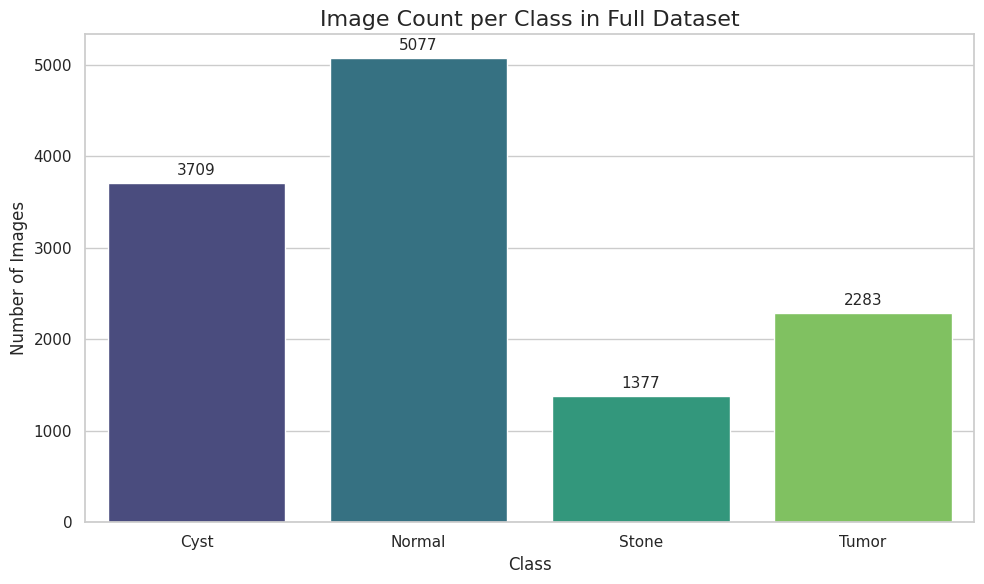

--- Distribution Plotting Complete ---


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("--- Plotting Class Distribution ---")
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes
counts = [class_counts[i] for i in range(len(class_names))]

df_counts = pd.DataFrame({
    'Class': class_names,
    'Count': counts
})

print("Class counts:")
print(df_counts)

# Create the Bar Plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=df_counts,
    x='Class',
    y='Count',
    palette='viridis'
)

ax.set_title('Image Count per Class in Full Dataset', fontsize=16)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_xlabel('Class', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11)

plt.tight_layout()
plt.show()

print("--- Distribution Plotting Complete ---")

In [8]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

print("--- Cell 3 (FINAL Version) ---")

# Model Hyperparameters
IMG_SIZE = 224
PATCH_SIZE = 16
EMBED_DIM = 384
NUM_HEADS = 6
NUM_LAYERS = 8
MLP_DIM = 384 * 4
NUM_CLASSES = 4

#  Data Path (The fast, local one)
DATA_PATH = "/tmp/CT-KIDNEY-DATASET"

#  Training Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.03
EPOCHS = 10 # best after 10 epoch model may start overfitting
VAL_SPLIT = 0.2

# Data Transforms
train_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.TrivialAugmentWide(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets and DataLoaders
try:
    full_dataset = ImageFolder(root=DATA_PATH, transform=train_transforms)
    print(f"Full dataset classes: {full_dataset.classes}")
    print(f"Found {len(full_dataset)} total images.")

    total_size = len(full_dataset)
    val_size = int(total_size * VAL_SPLIT)
    train_size = total_size - val_size

    train_subset, val_subset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    val_subset.dataset.transform = val_transforms
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Split into {len(train_subset)} training images and {len(val_subset)} validation images.")
    print("DataLoaders created successfully (with parallel workers).")

except Exception as e:
    print(f"An error occurred: {e}")

--- Cell 3 (FINAL Version) ---
Full dataset classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Found 12446 total images.
Split into 9957 training images and 2489 validation images.
DataLoaders created successfully (with parallel workers).


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("--- Cell 4: Defining ViT Model Classes ---")

#  Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels,
            embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):

        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Multi-Head Self-Attention

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        assert self.head_dim * num_heads == self.embedding_dim, "Embedding dim must be divisible by num heads"

        self.qkv_proj = nn.Linear(embedding_dim, embedding_dim * 3)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv_proj(x) # [B, N, C*3]
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled Dot-Product Attention
        attn_scores = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn_probs = F.softmax(attn_scores, dim=-1)

        context = attn_probs @ v

        # Concat heads and project
        context = context.transpose(1, 2).reshape(B, N, C)
        output = self.out_proj(context)
        return output

# Feed-Forward Network (MLP)
class FeedForward(nn.Module):
    def __init__(self, embedding_dim=768, mlp_dim=3072):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embedding_dim)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

# Transformer Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attn = MultiHeadAttention(embedding_dim, num_heads)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.ffn = FeedForward(embedding_dim, mlp_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-normalization
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = x + residual

        return x

#  The Complete ViT Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 num_classes=4, embedding_dim=768, num_heads=12,
                 num_layers=12, mlp_dim=3072, dropout=0.1):

        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embedding_dim)
        self.n_patches = self.patch_embed.n_patches

        # [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional Embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        # Transformer Encoder Stack
        self.encoders = nn.ModuleList([
            EncoderBlock(embedding_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) # [B, n_patches, embedding_dim]

        # Prepend [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # [B, n_patches + 1, embedding_dim]

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.dropout(x)

        # Pass through Transformer Encoder
        for encoder in self.encoders:
            x = encoder(x)

        # Get [CLS] token output
        cls_output = x[:, 0]

        # Normalize and classify
        cls_output = self.norm(cls_output)
        logits = self.classifier(cls_output)

        return logits

print("--- ViT Model Classes Defined Successfully ---")

--- Cell 4: Defining ViT Model Classes ---
--- ViT Model Classes Defined Successfully ---


In [10]:
import os
import torch
import torch.nn as nn
import time
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print("--- Cell 5: Initializing Training ---")

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model, Loss, and Optimizer
print("Initializing model...")
model = VisionTransformer(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    mlp_dim=MLP_DIM,
    num_classes=NUM_CLASSES
).to(device)
print("Model created and moved to device.")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
print("Loss, optimizer, and scheduler created.")

# Training and Validation Functions
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    # We wrap the loader with a timer for debugging
    epoch_start_time = time.time()
    for batch_idx, (inputs, labels) in enumerate(loader):
        batch_start_time = time.time()

        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # 2. Backward pass
        optimizer.zero_grad()
        loss.backward()

        # 3. Optimizer step
        optimizer.step()

        # Update statistics
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(logits, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        if batch_idx == 0:
            batch_end_time = time.time()
            print(f"    First batch processed in {batch_end_time - batch_start_time:.4f} seconds.")

    epoch_end_time = time.time()
    print(f"    Training epoch finished in {epoch_end_time - epoch_start_time:.2f} seconds.")
    epoch_loss = total_loss / total_samples
    epoch_acc = correct_preds.double() / total_samples
    return epoch_loss, epoch_acc.item()


def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            logits = model(inputs)
            loss = criterion(logits, labels)

            # Update statistics
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = total_loss / total_samples
    epoch_acc = correct_preds.double() / total_samples
    return epoch_loss, epoch_acc.item()


#  Training
print("\n--- Starting Training ---")
print("Waiting for the first batch...")

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)

    scheduler.step() # Update learning rate

    print(f"Epoch {epoch+1} Complete | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")
        print(f"    New best model saved with Val Acc: {val_acc:.4f}")

print("\n--- Training Finished ---")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

--- Cell 5: Initializing Training ---
Using device: cuda
Initializing model...
Model created and moved to device.
Loss, optimizer, and scheduler created.

--- Starting Training ---
Waiting for the first batch...

Epoch 1/50
    First batch processed in 0.5273 seconds.
    Training epoch finished in 94.53 seconds.
Epoch 1 Complete | Train Loss: 0.9464, Train Acc: 0.6438 | Val Loss: 0.9937, Val Acc: 0.6175
    New best model saved with Val Acc: 0.6175

Epoch 2/50
    First batch processed in 0.3312 seconds.
    Training epoch finished in 96.90 seconds.
Epoch 2 Complete | Train Loss: 0.4886, Train Acc: 0.8253 | Val Loss: 0.3797, Val Acc: 0.8638
    New best model saved with Val Acc: 0.8638

Epoch 3/50
    First batch processed in 0.3148 seconds.
    Training epoch finished in 94.57 seconds.
Epoch 3 Complete | Train Loss: 0.2111, Train Acc: 0.9271 | Val Loss: 0.1232, Val Acc: 0.9622
    New best model saved with Val Acc: 0.9622

Epoch 4/50
    First batch processed in 0.2834 seconds.
    T

KeyboardInterrupt: 

In [30]:
import torch
import torch.nn as nn
print("--- Loading Model ---")

# Re-define the Model Architecture
IMG_SIZE = 224
PATCH_SIZE = 16
EMBED_DIM = 384
NUM_HEADS = 6
NUM_LAYERS = 8
MLP_DIM = 384 * 4
NUM_CLASSES = 4

try:
    loaded_model = VisionTransformer(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        embedding_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        mlp_dim=MLP_DIM,
        num_classes=NUM_CLASSES
    )

    # Load the Saved Weights
    loaded_model.load_state_dict(torch.load("best_vit_model.pth"))

    # Prepare Model for Evaluation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = loaded_model.to(device)
    loaded_model.eval()

    print("Model 'best_vit_model.pth' loaded successfully!")

except NameError:
    print("\n--- ERROR ---")
    print("Could not find 'VisionTransformer' class.")
    print("Please paste all the ViT model classes (from Cell 4) into this cell.")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Could not find 'best_vit_model.pth'.")
    print("Make sure it's in your main Colab directory.")

--- Loading Model ---
Model 'best_vit_model.pth' loaded successfully!


--- Starting Evaluation ---
All predictions gathered.
Class names: ['Cyst', 'Normal', 'Stone', 'Tumor']

--- Classification Report ---
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       732
      Normal       1.00      1.00      1.00      1022
       Stone       0.99      1.00      0.99       278
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489



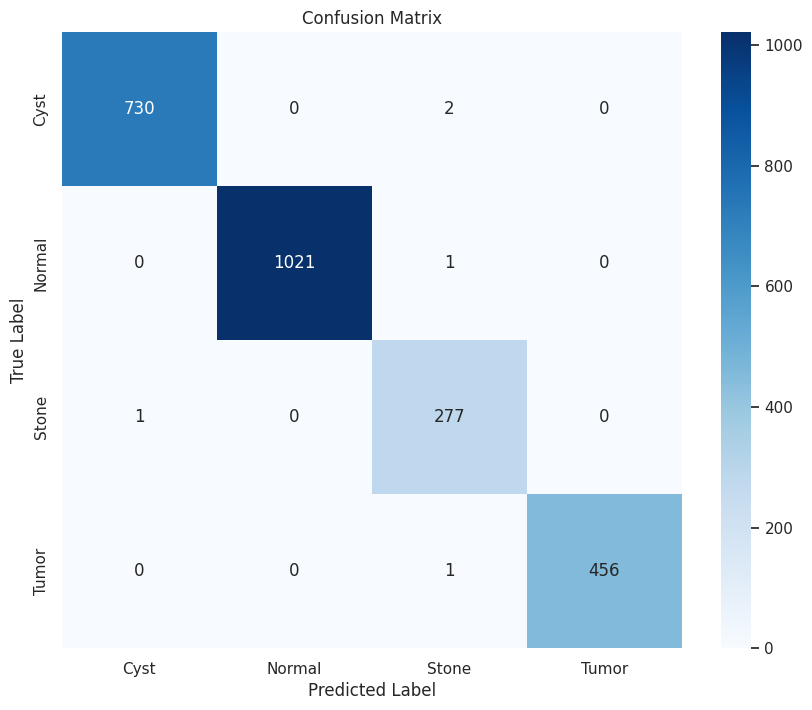

--- Evaluation Complete ---


In [31]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("--- Starting Evaluation ---")
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("All predictions gathered.")


class_names = full_dataset.classes
print(f"Class names: {class_names}")
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n--- Classification Report ---")
print(report)

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("--- Evaluation Complete ---")

# Plotting classification report.

--- Plotting Classification Metrics ---


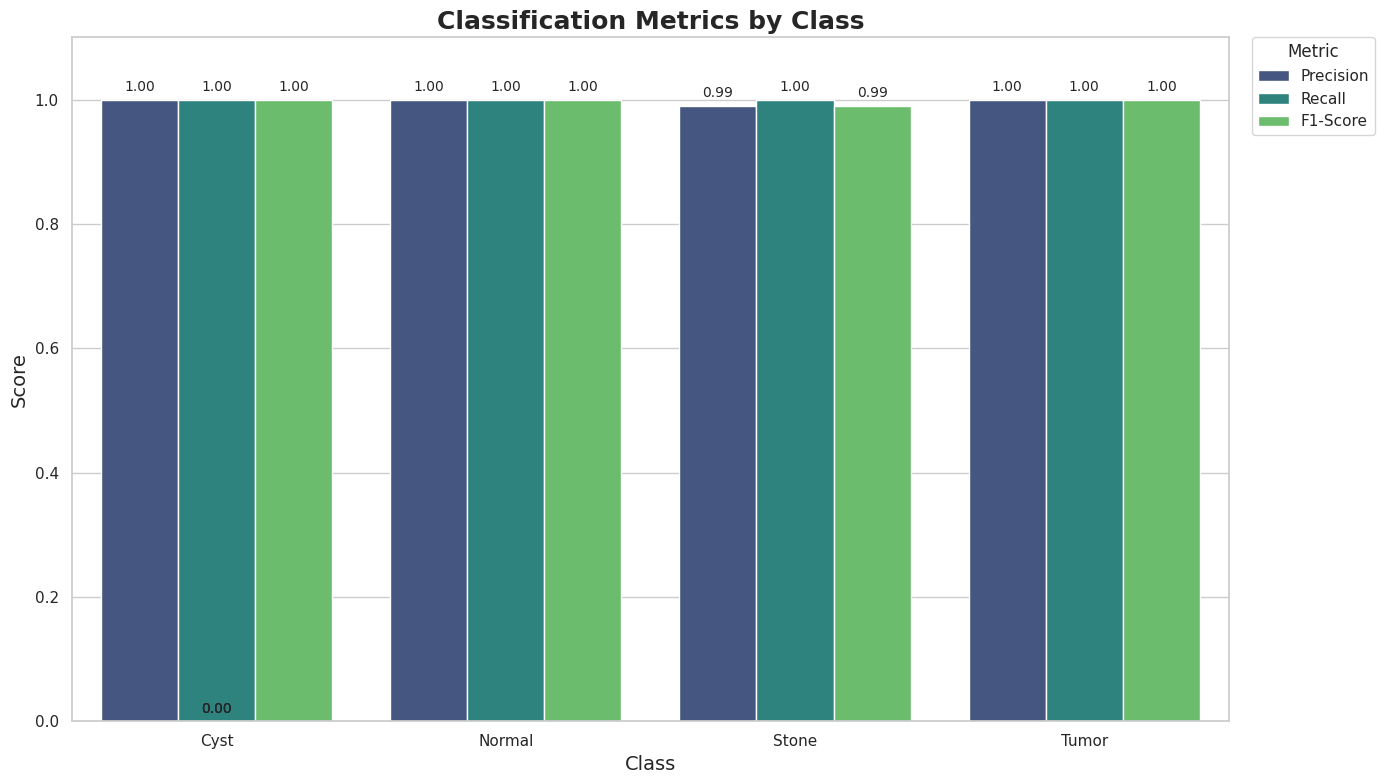

--- Plotting Complete ---


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Plotting Classification Metrics ---")
report_data = {
    'Class': ['Cyst', 'Normal', 'Stone', 'Tumor'],
    'Precision': [1.00, 1.00, 0.99, 1.00],
    'Recall': [1.00, 1.00, 1.00, 1.00],
    'F1-Score': [1.00, 1.00, 0.99, 1.00]
}

df = pd.DataFrame(report_data)
df_melted = df.melt('Class', var_name='Metric', value_name='Score')

# Create the Bar Plot
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x='Class',
    y='Score',
    hue='Metric',
    data=df_melted,
    palette='viridis'
)


ax.set_title('Classification Metrics by Class', fontsize=18, fontweight='bold')
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylim(0, 1.1)
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

print("--- Plotting Complete ---")

#Plotting Incorrect Predictions

--- Finding and Plotting Incorrect Predictions ---
Found 5 incorrect predictions. Plotting...


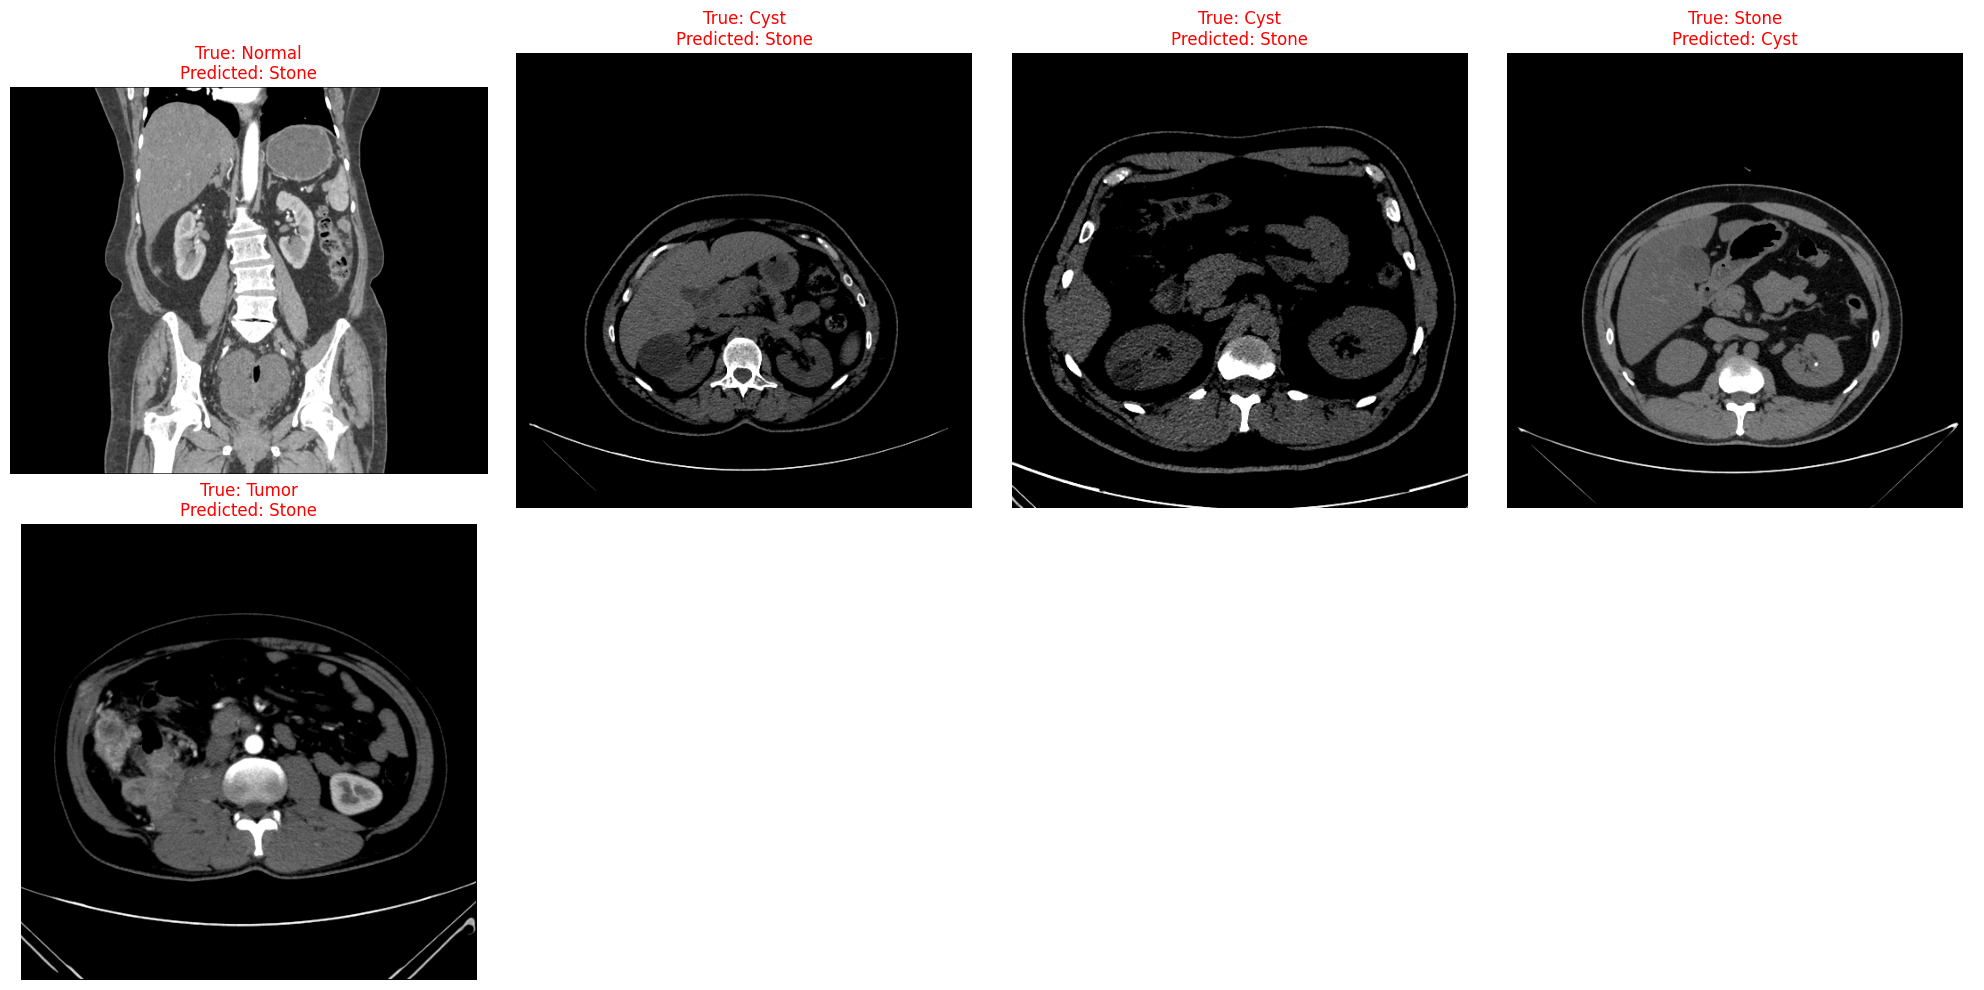

--- Mismatch Plotting Complete ---


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print("--- Finding and Plotting Incorrect Predictions ---")
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)
class_names = full_dataset.classes
mismatch_indices = np.where(all_preds_np != all_labels_np)[0]

if len(mismatch_indices) == 0:
    print("\n No incorrect predictions found in the validation set!")
else:
    print(f"Found {len(mismatch_indices)} incorrect predictions. Plotting...")

    # Plot the Mismatched Images
    num_to_plot = min(len(mismatch_indices), 16)
    fig, axes = plt.subplots(int(np.ceil(num_to_plot / 4)), 4, figsize=(20, 5 * int(np.ceil(num_to_plot / 4))))
    axes = axes.flatten()

    for i, mismatch_idx in enumerate(mismatch_indices[:num_to_plot]):
        original_idx = val_subset.indices[mismatch_idx]
        image_path, true_label_idx = full_dataset.imgs[original_idx]
        true_label = class_names[true_label_idx]
        pred_label = class_names[all_preds_np[mismatch_idx]]
        img = Image.open(image_path)
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color='red', fontsize=12)
        ax.axis('off')

    for j in range(num_to_plot, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

print("--- Mismatch Plotting Complete ---")

# Ploting ViT Attention Map

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("Loading Model")
IMG_SIZE = 224
PATCH_SIZE = 16
EMBED_DIM = 384
NUM_HEADS = 6
NUM_LAYERS = 8
MLP_DIM = 384 * 4
NUM_CLASSES = 4

#  ALL ViT MODEL CLASSES

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        assert self.head_dim * num_heads == self.embedding_dim, "Embedding dim must be divisible by num heads"
        self.qkv_proj = nn.Linear(embedding_dim, embedding_dim * 3)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn_probs = F.softmax(attn_scores, dim=-1)

        self.attn_probs = attn_probs
        context = attn_probs @ v
        context = context.transpose(1, 2).reshape(B, N, C)
        output = self.out_proj(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, embedding_dim=768, mlp_dim=3072):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embedding_dim)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attn = MultiHeadAttention(embedding_dim, num_heads)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.ffn = FeedForward(embedding_dim, mlp_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = x + residual
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 num_classes=4, embedding_dim=768, num_heads=12,
                 num_layers=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embedding_dim)
        self.n_patches = self.patch_embed.n_patches
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, embedding_dim))
        self.dropout = nn.Dropout(dropout)
        self.encoders = nn.ModuleList([
            EncoderBlock(embedding_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        for encoder in self.encoders:
            x = encoder(x)
        cls_output = x[:, 0]
        cls_output = self.norm(cls_output)
        logits = self.classifier(cls_output)
        return logits

# Initialize Model and Load Weights
try:
    loaded_model = VisionTransformer(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        embedding_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        mlp_dim=MLP_DIM,
        num_classes=NUM_CLASSES
    )

    # Load the saved model
    loaded_model.load_state_dict(torch.load("best_vit_model.pth"))

    # Prepare model for evaluation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = loaded_model.to(device)
    loaded_model.eval()

    print("\nModel 'best_vit_model.pth' loaded successfully into the *corrected* structure!")

except Exception as e:
    print(f"\n--- An Error Occurred ---: {e}")

Loading Model

Model 'best_vit_model.pth' loaded successfully into the *corrected* structure!


--- Plotting ViT Attention Maps ---


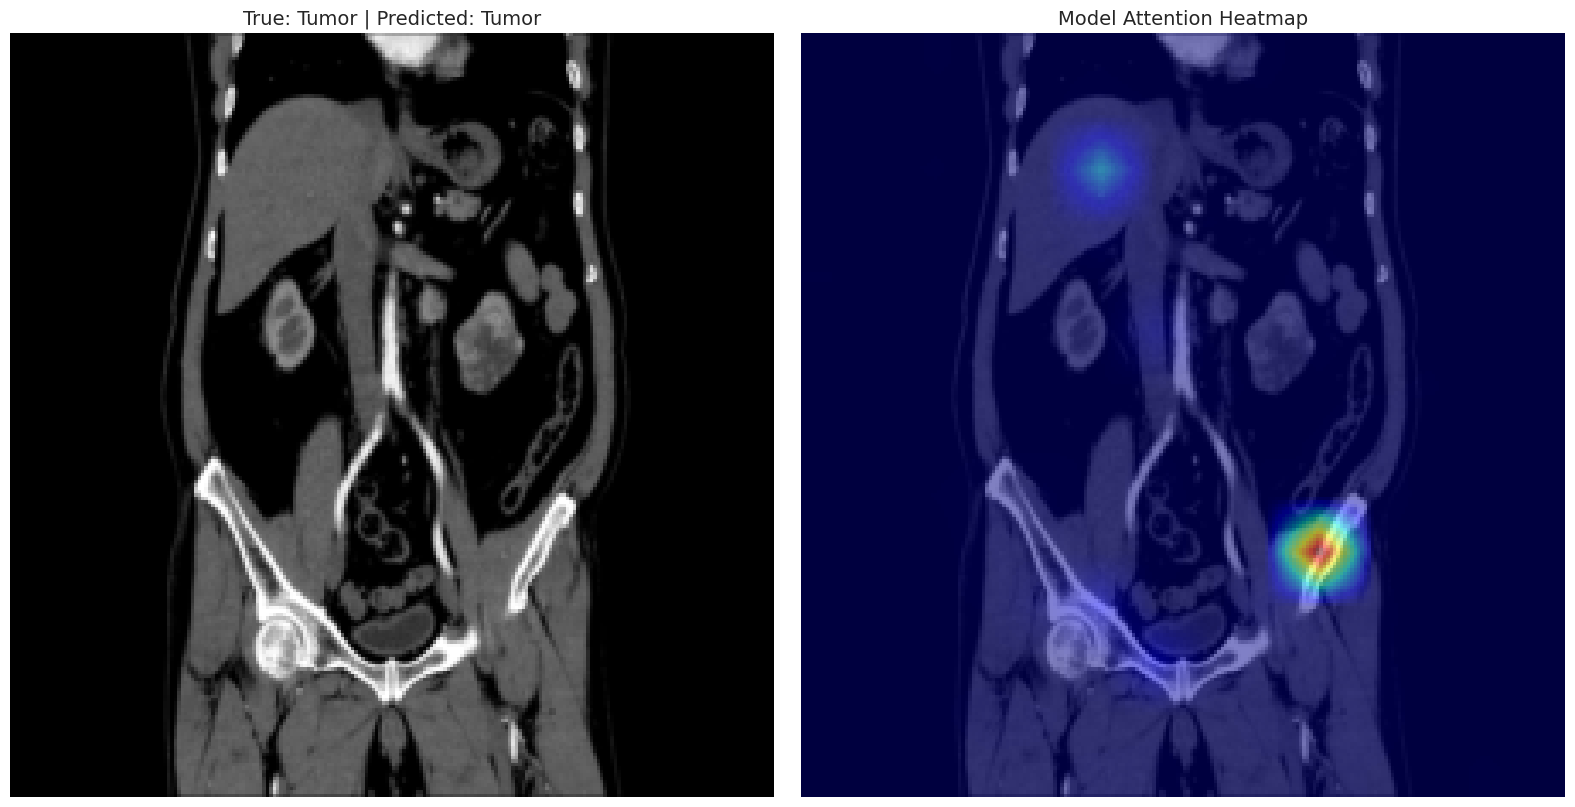

In [45]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

print("--- Plotting ViT Attention Maps ---")
def get_random_image():
    random_val_idx = random.choice(range(len(val_subset)))
    original_idx = val_subset.indices[random_val_idx]
    image_path, true_label_idx = full_dataset.imgs[original_idx]
    true_label = class_names[true_label_idx]
    img = Image.open(image_path).convert('RGB')
    img_tensor = val_transforms(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    plot_img = v2.Resize((IMG_SIZE, IMG_SIZE))(img)

    return img_tensor, plot_img, true_label
try:
    # Get a test image
    img_tensor, plot_img, true_label = get_random_image()
    with torch.no_grad():
        logits = loaded_model(img_tensor)

    # Get prediction
    pred_label = class_names[torch.argmax(logits, dim=1).item()]

    # Extract and Process the Attention Map
    attention_map = loaded_model.encoders[-1].attn.attn_probs
    att_map = attention_map[0, :, 0, 1:].squeeze()
    att_map = att_map.mean(dim=0)
    n_patches_sqrt = int(att_map.shape[0]**0.5)
    att_map_2d = att_map.reshape(n_patches_sqrt, n_patches_sqrt).cpu().numpy()
    att_map_resized = F.interpolate(
        torch.tensor(att_map_2d).unsqueeze(0).unsqueeze(0),
        scale_factor=PATCH_SIZE, # 16
        mode='bilinear',
        align_corners=False
    ).squeeze().numpy()

    # Plot the Results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Original Image
    ax1.imshow(plot_img)
    ax1.axis('off')
    ax1.set_title(f"True: {true_label} | Predicted: {pred_label}", fontsize=14)

    # Heatmap Overlay
    ax2.imshow(plot_img)
    ax2.imshow(att_map_resized, cmap='jet', alpha=0.5)
    ax2.axis('off')
    ax2.set_title("Model Attention Heatmap", fontsize=14)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")